# **1 - Perkenalan**

---



Bab pengenalan harus diisi dengan identitas, gambaran besar dataset yang digunakan, dan objective yang ingin dicapai.

Name : Andik Al Fauzi

Objective : Membuat model untuk memprediksi stress atau tidaknya seseorang berdasarkan kalimat yang dibuatnya.

## 1.1 Background

Stress adalah sesuatu yang harus dihindari oleh seseorang, karena dapat mengakibatkan segala sesuatunya menjadi terhambat. Psikologis dari orang tersebut pun akan dapat terganggu jika terus mengalami stress, dan jika hal itu terjadi maka orang tersebut harus mendapatkan terapi psikologis agar kesehatan mental orang tersebut akan dapat membaik.

Oleh karena itu akan dilakukan analisa stress berdasarkan kalimat yang dibuat seseorang dengan menggunakan model ANN untuk mengetahui apakah orang tersebut dalam kondisi stress atau tidak. Sehingga nantinya bisa dilakukan pengobatan lebih lanjut jika memang orang tersebut terindikasi sedang stress.

## 1.2 Gambaran Dataset

Dataset diambil dari Kaggle dengan judul [Human Stress Prediction](https://www.kaggle.com/datasets/kreeshrajani/human-stress-prediction). 
Data no-stress label = 0, data stress label = 1

# **3 - Import Libraries**

---



Cell pertama pada notebook harus berisi dan hanya berisi semua library yang digunakan dalam project.

In [1]:
# Installing other library
!pip install unidecode
!pip install Kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 4.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [152]:
# Importing libraries
import pandas as pd
import numpy as np
import re
import string
import tensorflow as tf

import seaborn as sns
import collections
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from unidecode import unidecode
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Input, LSTM, GRU, Dropout, SpatialDropout1D
from tensorflow.keras.models import Model, Sequential
from nltk.stem import LancasterStemmer, PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay

# Importing Libraries
import pickle
import json

# Warning Library
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **4 - Data Loading**

---



Bagian ini berisi proses penyiapan data sebelum dilakukan eksplorasi data lebih lanjut. Proses Data Loading dapat berupa memberi nama baru untuk setiap kolom, mengecek ukuran dataset, dll.

In [3]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# persiapan Data Loading dan set kaggle
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle
!cp /content/drive/MyDrive/Haktiv8/kaggle.json ~/.kaggle

# Cek kaggle berhasil berhasil dijalankan
!ls ~/.kaggle

Mounted at /content/drive
cp: cannot stat 'kaggle.json': No such file or directory
kaggle.json


In [4]:
# Get kaggle dataset
!kaggle datasets download -d kreeshrajani/human-stress-prediction

100% 554k/554k [00:00<00:00, 948kB/s]
100% 554k/554k [00:00<00:00, 947kB/s]


In [5]:
# Extract dataset kaggle
!unzip -q /content/human-stress-prediction.zip

In [8]:
# Create a dataframe
data = pd.read_csv('/content/Stress.csv')

# Display
data.head(10)

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005
5,relationships,7tx7et,"(30, 35)",I think he doesn't want to put in the effort f...,1,1.0,1517274027
6,domesticviolence,7iphly,"[25, 30]",It was a big company so luckily I didn't have ...,0,0.8,1512854409
7,anxiety,5m3k80,"(5, 10)",It cleared up and I was okay but. On Monday ...,1,0.8,1483582174
8,relationships,7nhy1v,"(50, 55)",I actually give an assistant half my emergency...,1,0.6,1514843984
9,assistance,61eiq6,"[15, 20]",I just feel like the street life has fucked my...,1,1.0,1490428087


# **5 - Exploratory Data Analysis (EDA)**

---

Bagian ini berisi eksplorasi data pada dataset diatas dengan menggunakan query, grouping, visualisasi sederhana, dan lain sebagainya.



In [9]:
# Decribe data
data.describe()

,label,confidence,social_timestamp
count,2838.000000,2838.000000,2.838000e+03
mean,0.524313,0.808972,1.518107e+09
std,0.499497,0.177038,1.552209e+07
min,0.000000,0.428571,1.483274e+09
25%,0.000000,0.600000,1.509698e+09
50%,1.000000,0.800000,1.517066e+09
75%,1.000000,1.000000,1.530898e+09
max,1.000000,1.000000,1.542592e+09


In [10]:
# Check unique value
print('Unique value - label : ')
print(data.label.unique())
print('')
print('Unique value - Confidence : ')
print(data.confidence.unique())
print('')
print('Unique value - Subreddit : ')
print(data.subreddit.unique())

Unique value - label : 
[1 0]

Unique value - Confidence : 
[0.8        1.         0.6        0.57142857 0.83333333 0.85714286
 0.5        0.71428571 0.66666667 0.42857143]

Unique value - Subreddit : 
['ptsd' 'assistance' 'relationships' 'survivorsofabuse' 'domesticviolence'
 'anxiety' 'homeless' 'stress' 'almosthomeless' 'food_pantry']


In [11]:
# Check stress and no stress
data.label.value_counts()

1    1488
0    1350
Name: label, dtype: int64

Data Balance

Text(0.5, 1.0, 'Label Distribution')

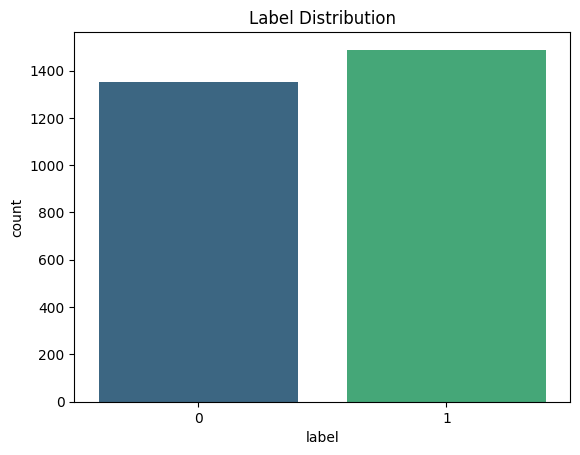

In [12]:
# Plotting data
sns.countplot(x=data.label, palette='viridis')
plt.title('Label Distribution')

In [13]:
# Missing value
data.isnull().sum()

subreddit           0
post_id             0
sentence_range      0
text                0
label               0
confidence          0
social_timestamp    0
dtype: int64

No data missing

In [14]:
# Check duplicated
data.duplicated().sum()

0

No duplicated data

Average of Text :  85.84425651867512


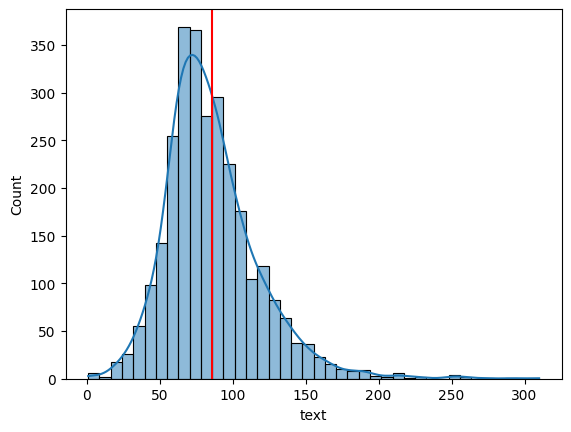

In [15]:
# Word distribution
textLen = data['text'].apply(lambda x: len(x.split(' ')))
sns.histplot(textLen, bins=40, kde=True)
plt.axvline(np.mean(textLen), color='Red')
print('Average of Text : ', np.mean(textLen))

85.84 of mean text length

Average no stress text :  82.33407407407407
Average stress text :  89.02889784946237


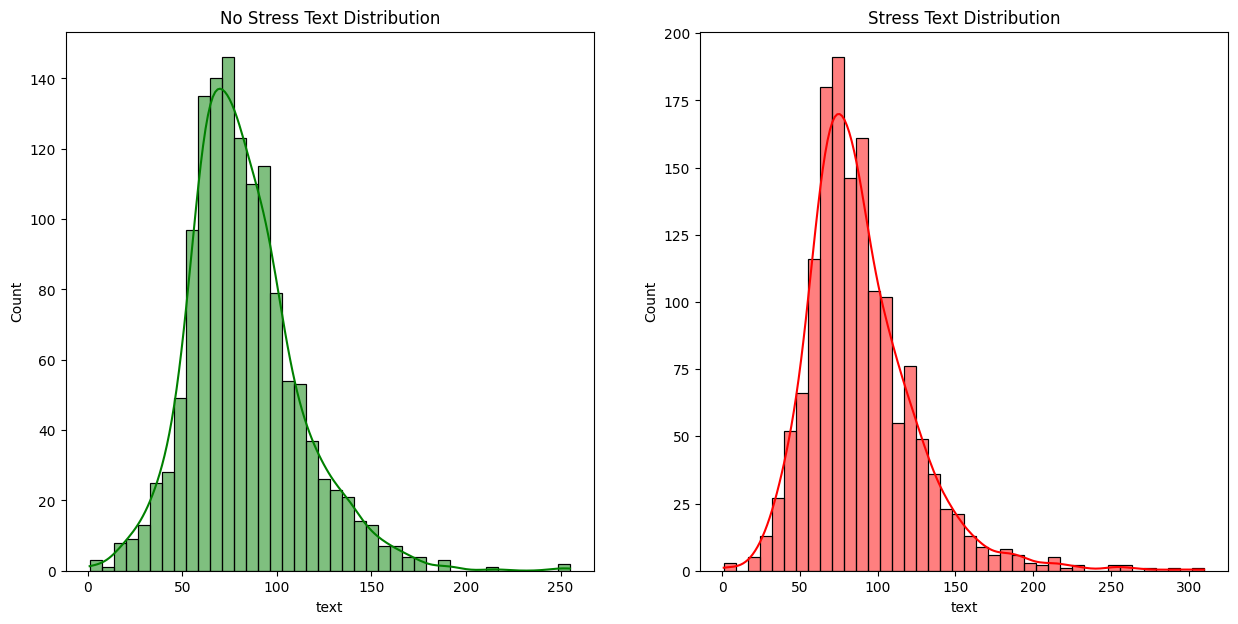

In [16]:
# Visualize
plt.figure(figsize=(15, 7))

# Visualize of no stress text
plt.subplot(1, 2, 1)
sns.histplot(textLen[data.label == 0], color='Green', bins=40, kde=True)
plt.title('No Stress Text Distribution')
print('Average no stress text : ', np.mean(textLen[data.label == 0]))

# Visualize of stress text
plt.subplot(1, 2, 2)
sns.histplot(textLen[data.label == 1], color='Red', bins=40, kde=True)
plt.title('Stress Text Distribution')
print('Average stress text : ', np.mean(textLen[data.label == 1]))

Kalimat yang mengkategorikan jika orang tersebut sedang stress lebih banyak yaitu rata-rata 89 kata dibanding dengan yang tidak stress dengan rata-rata 82 kata. Hal ini dapat diartikan jika seseorang sedang stress mereka akan lebih banyak bicara atau kalimat yang mereka keluarkan lebih banyak untuk mengungkapkan isi hati dan memperlihatkan jika memang mereka dalam kondisi yang tertekan.

In [17]:
# Sort by no-stress data
noStressData = data.loc[data.label == 0]

# Sort by stress data
stressData = data.loc[data.label == 1]

In [18]:
# Count of confidence level 
print('Confidence level of No-Stress : ')
print(noStressData.confidence.value_counts())
print('='*30)
print('Confidence level of Stress : ')
print(stressData.confidence.value_counts())

Confidence level of No-Stress : 
1.000000    541
0.800000    261
0.600000    240
0.571429    223
0.833333     42
0.666667     32
0.714286      6
0.857143      5
Name: confidence, dtype: int64
Confidence level of Stress : 
1.000000    587
0.800000    334
0.600000    256
0.571429    146
0.833333     57
0.666667     39
0.500000     34
0.857143     25
0.714286      8
0.428571      2
Name: confidence, dtype: int64


Text(0.5, 1.0, 'Confidence Distribution of Stress')

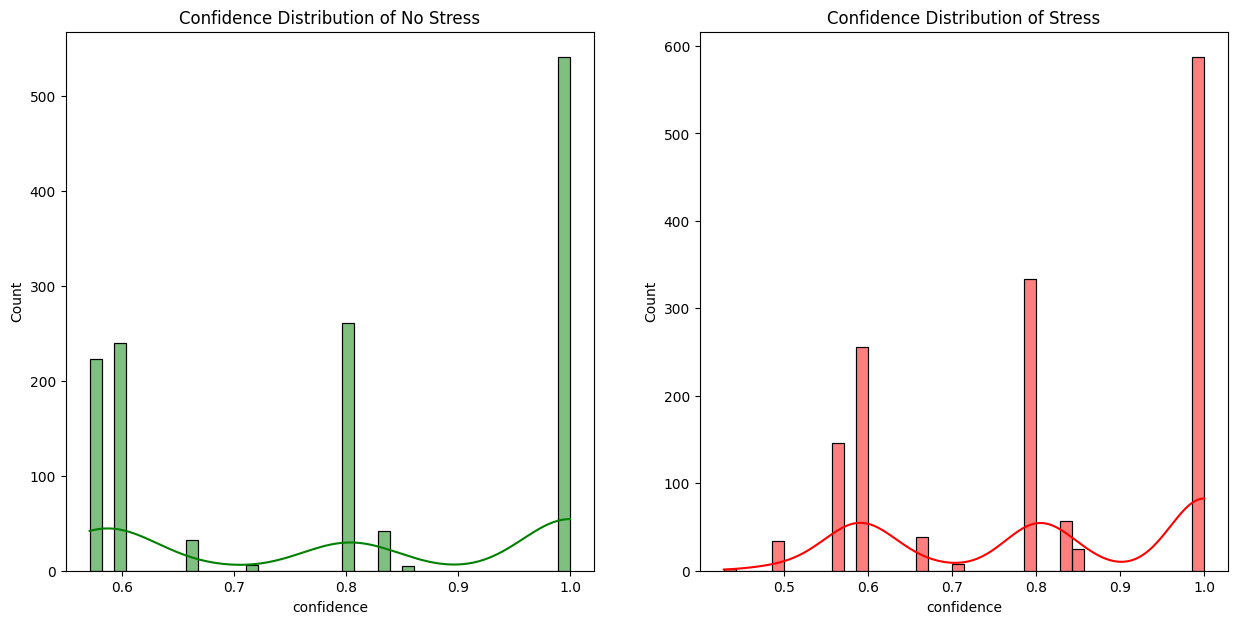

In [19]:
# Visualize of confidence
plt.figure(figsize=(15, 7))

# Visualize of no stress text
plt.subplot(1, 2, 1)
sns.histplot(noStressData.confidence, color='Green', bins=40, kde=True)
plt.title('Confidence Distribution of No Stress')

# Visualize of stress text
plt.subplot(1, 2, 2)
sns.histplot(stressData.confidence, color='Red', bins=40, kde=True)
plt.title('Confidence Distribution of Stress')

Dapat dilihat tingkat kepercayaan dari suatu kalimat yang menandakan stress berada diatas angka 0.5, yang mana dapat diartikan bahwa kalimat-kalimat yang dikeluarkan memang betul menandakan bahwa kondisi orang tersebut sedang dalam keadaan stress atau tidak. Dan begitupun sebaliknya, tingkat kepercayaan terhadap suatu kalimat yang no-stress diatas angka 0.5 yang menandakan kalimat tersebut memang benar jika mereka tidak dalam kondisi stress

In [20]:
# Count of subreddit 
print('Subreddit of No-Stress : ')
print(noStressData.subreddit.value_counts())
print('='*30)
print('Subreddit level of Stress : ')
print(stressData.subreddit.value_counts())

Subreddit of No-Stress : 
relationships       305
ptsd                252
assistance          184
anxiety             172
survivorsofabuse    133
domesticviolence    114
homeless            105
almosthomeless       33
stress               29
food_pantry          23
Name: subreddit, dtype: int64
Subreddit level of Stress : 
ptsd                332
anxiety             331
relationships       247
domesticviolence    202
survivorsofabuse    112
assistance          105
homeless             63
almosthomeless       47
stress               35
food_pantry          14
Name: subreddit, dtype: int64


Data no-stress didukung oleh mereka yang memiliki `relationship` yang baik dimana 305 koresponden menduduki peringkat pertama dari kategori `relationship`. Sementara koresponden yang stress memiliki `PTSD` dan `Anxiety` yang tinggi dimana ada 300 lebih koresponden yang mengalami `PTSD` masa lampau yang mungkin masih mereka alami sehingga tingkat stress yang dialami cukup tinggi dengan tingkat `anxiety` yang tinggi pula. 

Text(0.5, 1.0, 'Subreddit Distribution of Stress')

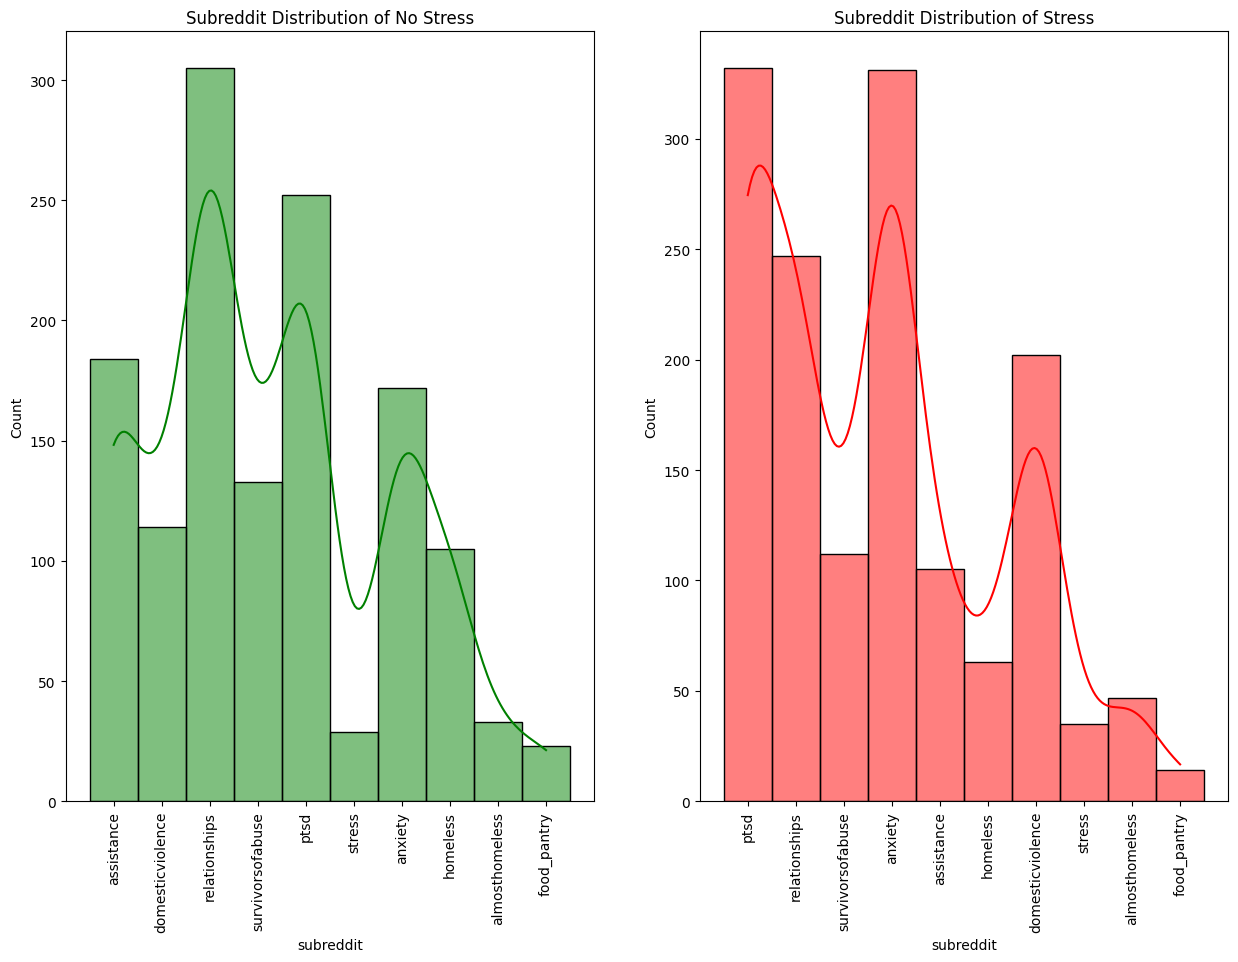

In [21]:
# Visualize of subreddit
plt.figure(figsize=(15, 10))

# Visualize of no stress text
plt.subplot(1, 2, 1)
sns.histplot(noStressData.subreddit, color='Green', bins=40, kde=True)
plt.xticks(rotation=90)
plt.title('Subreddit Distribution of No Stress')

# Visualize of stress text
plt.subplot(1, 2, 2)
sns.histplot(stressData.subreddit, color='Red', bins=40, kde=True)
plt.xticks(rotation=90)
plt.title('Subreddit Distribution of Stress')

Dari visualisasi diatas dapat disimpulkan jika
1. Menjalin relationship dengan lawan jenis menjadi alasan tertinggi seseorang untuk menghindari stress, hal ini mungkin dikaitkan lawan jenis tersebut bisa menjadi tempat untuk berbagi cerita dan masalah sehingga orang tersebut dapat terhindar dari stress. 
2. Menurut [Alodokter](https://www.alodokter.com/ptsd), PTSD adalah suatu gejala yang timbul akan adanya traumatic masa lampau. Hal ini pula yang dijadikan alasan seseorang untuk bisa menghindari stress dengan cara tidak mengingat atau mengungkit kembali apa yang telah dialami. Bisa dikatakan orang tersebut telah berdamai dengan masa lalu yang kelam dan bisa menerimanya dengan baik sehingga kemungkinan untuk tidak stress dapat diminimalisir
3. Berbanding terbalik dengan kesimpulan diatas, PTSD pun bisa menjadi penyebab seseorang mengalami tingkat stress yang tinggi. Hal ini diakibatkan adanya hal-hal yang dapat memicu mereka untuk teringat kembali masa lalu yang kelam, sehingga mereka mengalami stress.
4. Anxiety pun menyebabkan tingkat stress yang cukup tinggi. Hal ini wajar jika tingkat kegelisahan seseorang semakin tinggi maka stress pun dapat timbul. Terlebih lagi jika seseorang memiliki tingkat kecemasan yang tinggi terhadap berbagai hal yang belum dihadapi maka orang tersebut akan semakin stress. 

In [22]:
# copy the dataset
copyData = data.copy()

# find length of text
copyData['char_length'] = data['text'].apply(lambda x: len(x))

# Find mean of kata-kata
copyData['avg_word'] = data['text'].map(lambda x: np.mean([len(z) for z in str(x).split()]))

# Find count of word
copyData['word_count'] = data['text'].map(lambda x: len(x.split()))

# find hastag
copyData['hastag'] = data['text'].map(lambda x: x.count('#'))

# Display
copyData

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,char_length,avg_word,word_count,hastag
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.800000,1521614353,571,4.061947,113,0
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.000000,1527009817,588,4.453704,108,0
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.800000,1535935605,847,4.108434,166,0
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.600000,1516429555,1277,3.681319,273,0
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.800000,1539809005,533,5.000000,89,0
...,...,...,...,...,...,...,...,...,...,...,...
2833,relationships,7oee1t,"[35, 40]","* Her, a week ago: Precious, how are you? (I i...",0,1.000000,1515187044,438,3.771739,92,0
2834,ptsd,9p4ung,"[20, 25]",I don't have the ability to cope with it anymo...,1,1.000000,1539827412,728,4.400000,135,0
2835,anxiety,9nam6l,"(5, 10)",In case this is the first time you're reading ...,0,1.000000,1539269312,848,5.288889,135,0
2836,almosthomeless,5y53ya,"[5, 10]",Do you find this normal? They have a good rela...,0,0.571429,1488938143,355,4.235294,68,0


<Axes: xlabel='char_length', ylabel='Density'>

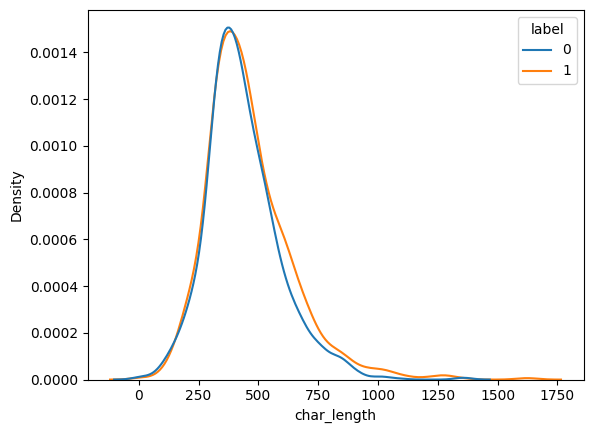

In [23]:
# Visualize base on char_length
sns.kdeplot(data = copyData, x = 'char_length', hue='label')

Dapat disimpulkan dari visualisasi diatas bahwa jika seseorang yang sedang mengalami stress biasanya akan memberikan lebih banyak huruf dibanding mereka yang tidak stress. Hal ini bisa dikaitkan jika kurangnya fokus mereka dalam mengendalikan emosi sehingga berdampak pada banyaknya huruf-huruf yang mereka ucapkan.

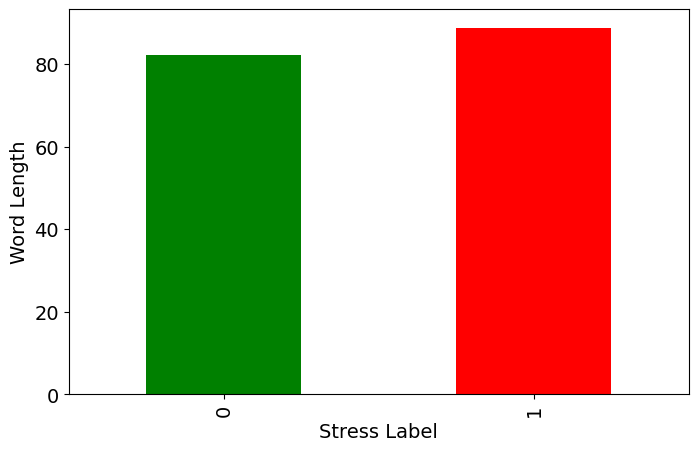

In [24]:
# Create visualization word base on word_length
wordMean = copyData.groupby('label')['word_count'].mean().plot(kind='bar', figsize=(8, 5), color=['green', 'red'])
plt.xlabel('Stress Label', fontsize = 14)
plt.ylabel('Word Length', fontsize = 14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Berbanding lurus dengan pernyataan sebelumnya, mereka yang sedang stress pun mengucapkan lebih banyak kalimat dibanding yang tidak stress.

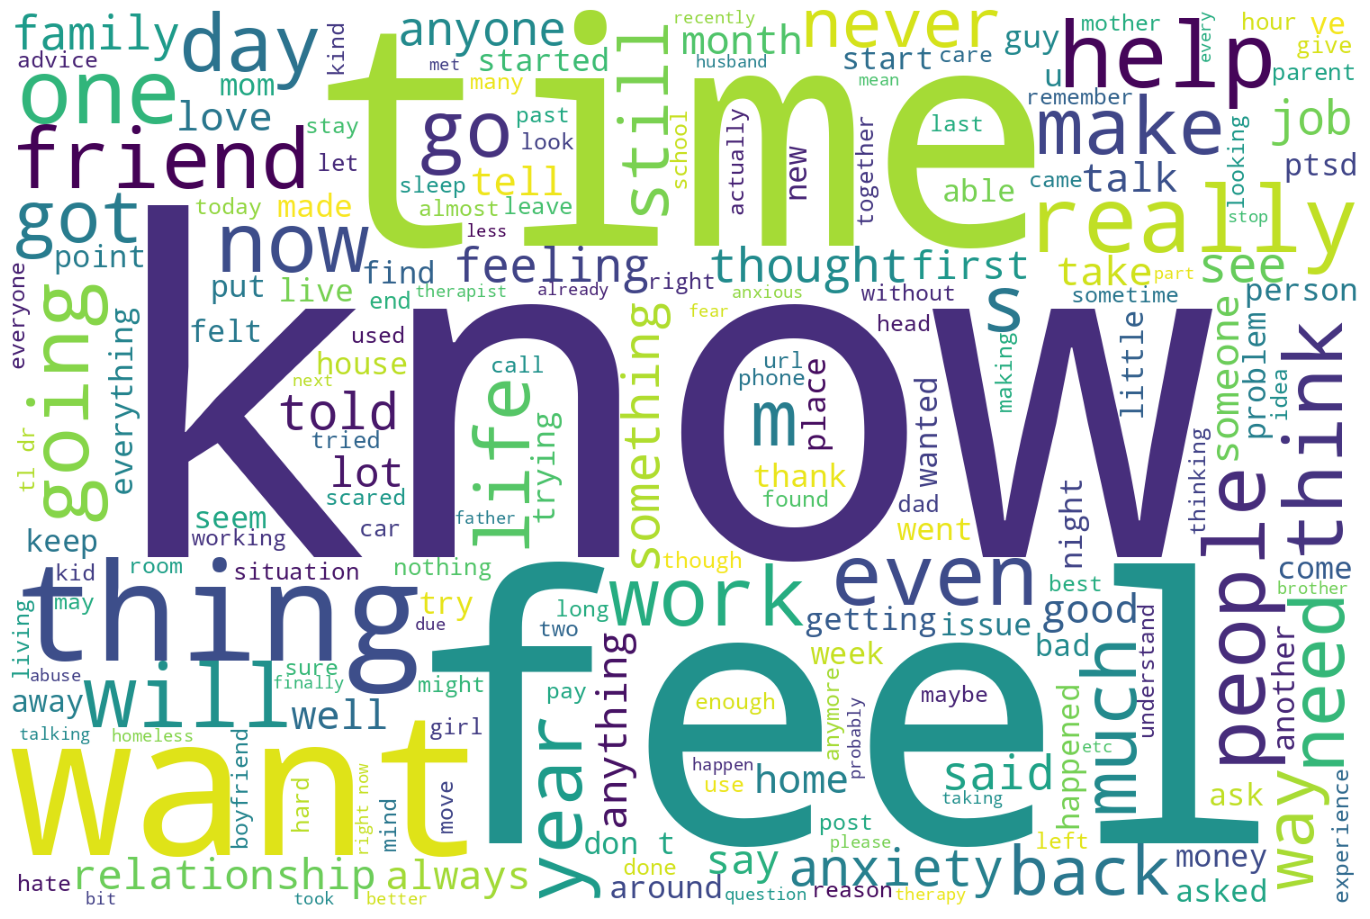

In [25]:
# Wordcloud function all data
# Mengambil data text untuk melihat frequency data
allText = data['text'].tolist()

# Join list and lowercase
allText = ' '.join(allText).lower()

# Define wordcloud
allWordcloud = WordCloud(width = 1500, height = 1000,
                              background_color = 'white', 
                              min_font_size = 10).generate(allText)

# Plot wordcloud
plt.figure(figsize = (16,9), facecolor=None)
plt.imshow(allWordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [26]:
# Make dictionary
allDictText = allWordcloud.process_text(allText)

# Sort dictionary
wordFreqAll = {k : v for k, v in sorted (allDictText.items(), reverse = True, key=lambda item:item[1])}

# Use word
relFreqAll = allWordcloud.words_

# Print top 10 frequency of word
print(list(wordFreqAll.items())[:10])
print()
print(list(relFreqAll.items())[:10])

[('know', 811), ('feel', 774), ('time', 708), ('want', 579), ('thing', 566), ('really', 552), ('one', 543), ('help', 543), ('will', 500), ('even', 490)]

[('know', 1.0), ('feel', 0.9543773119605425), ('time', 0.872996300863132), ('want', 0.7139334155363748), ('thing', 0.6979038224414303), ('really', 0.6806411837237978), ('one', 0.6695437731196054), ('help', 0.6695437731196054), ('will', 0.6165228113440198), ('even', 0.6041923551171393)]


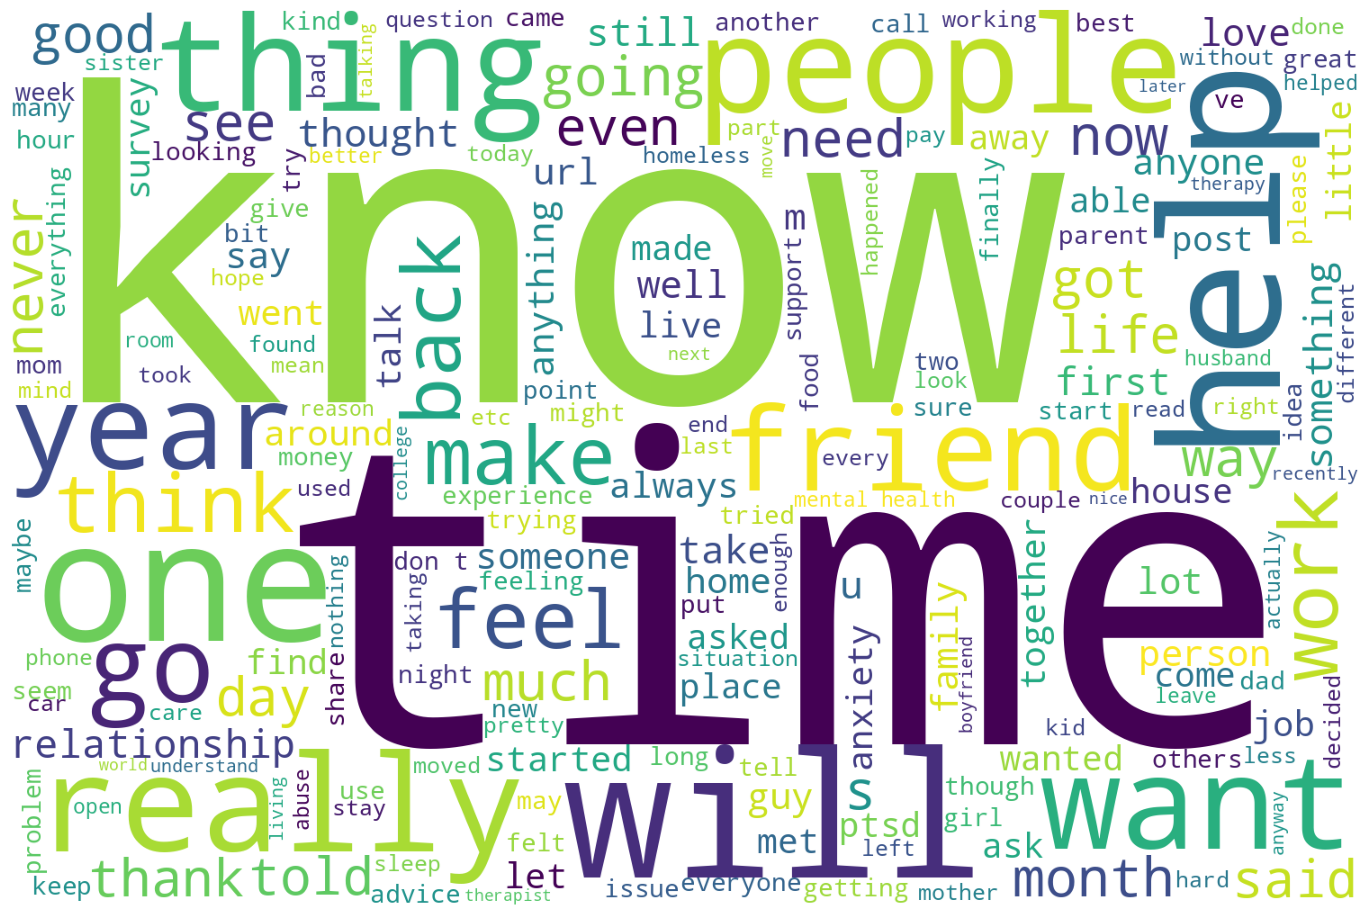

In [27]:
# Wordcloud function no-stress data
# Mengambil data text untuk melihat frequency data
noStressText = noStressData['text'].tolist()

# Join list and lowercase
noStressText = ' '.join(noStressText).lower()

# Define wordcloud
wordCloudNoStress = WordCloud(width = 1500, height = 1000,
                              background_color = 'white', 
                              min_font_size = 10).generate(noStressText)

# Plot wordcloud
plt.figure(figsize = (16,9), facecolor=None)
plt.imshow(wordCloudNoStress)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

Gambar diatas adalah beberapa text yang sering muncul dan ada di dalam dataset. Kata `know`, `time`, `will` dan `help` merupakan kata-kata yang paling sering muncul dan digunakan seseorang jika orang tersebut tidak sedang stress.

In [28]:
# Make dictionary
textDictNoStress = wordCloudNoStress.process_text(noStressText)

# Sort dictionary
wordFreqNoStress = {k : v for k, v in sorted (textDictNoStress.items(), reverse = True, key=lambda item:item[1])}

# Use word
relFreqNoStress = wordCloudNoStress.words_

# Print top 10 frequency of word
print(list(wordFreqNoStress.items())[:10])
print()
print(list(relFreqNoStress.items())[:10])

[('know', 330), ('time', 327), ('will', 295), ('one', 268), ('help', 261), ('really', 249), ('people', 249), ('thing', 235), ('want', 232), ('year', 232)]

[('know', 1.0), ('time', 0.990909090909091), ('will', 0.8939393939393939), ('one', 0.8121212121212121), ('help', 0.7909090909090909), ('really', 0.7545454545454545), ('people', 0.7545454545454545), ('thing', 0.7121212121212122), ('want', 0.703030303030303), ('year', 0.703030303030303)]


Berdasarkan hasil diatas menunjukan kalimat yang digunakan untuk mengekspresikan kondisi seseorang yang tidak stress adalah : 
1. `know` sebanyak 330 kali
2. `time` sebanyak 327 kali
3. `will` sebanyak 295 kali
4. `one` sebanyak 268 kali
5. `help` sebanyak 261 kali
6. `really` sebanyak 249 kali
7. `people` sebanyak 249 kali
8. `thing` sebanyak 235 kali
9. `want` sebanyak 232 kali
10. `year` sebanyak 232 kali

Berdasarkan hasil diatas, dapat disimpulkan kata-kata yang sering digunakan untuk menandakan jika seseorang tidak stress adalah
1. `know`. kata ini sangat sering digunakan seseorang jika ingin mengungkapkan isi hati mereka pada saat itu. Dapat dikatakan orang tersebut memang sangat mengetahui kondisi psikologis mereka tidak sedang stress
2. `time`. berkaitan dengan pernyataan sebelumnya. Kata ini menunjukan waktu pada saat suatu kalimat diungkapkan, sehingga lawan bicara dapat mengetahui apa yang koresponden rasakan pada saat itu
3. `will`. Kata ini dapat diartikan apa yang koresponden ingin lakukan pada saat suatu kalimat diungkapkan. Dengan kata lain memang orang tersebut tahu persis apa yang ingin dilakukan sesuai keinginan pada saat itu

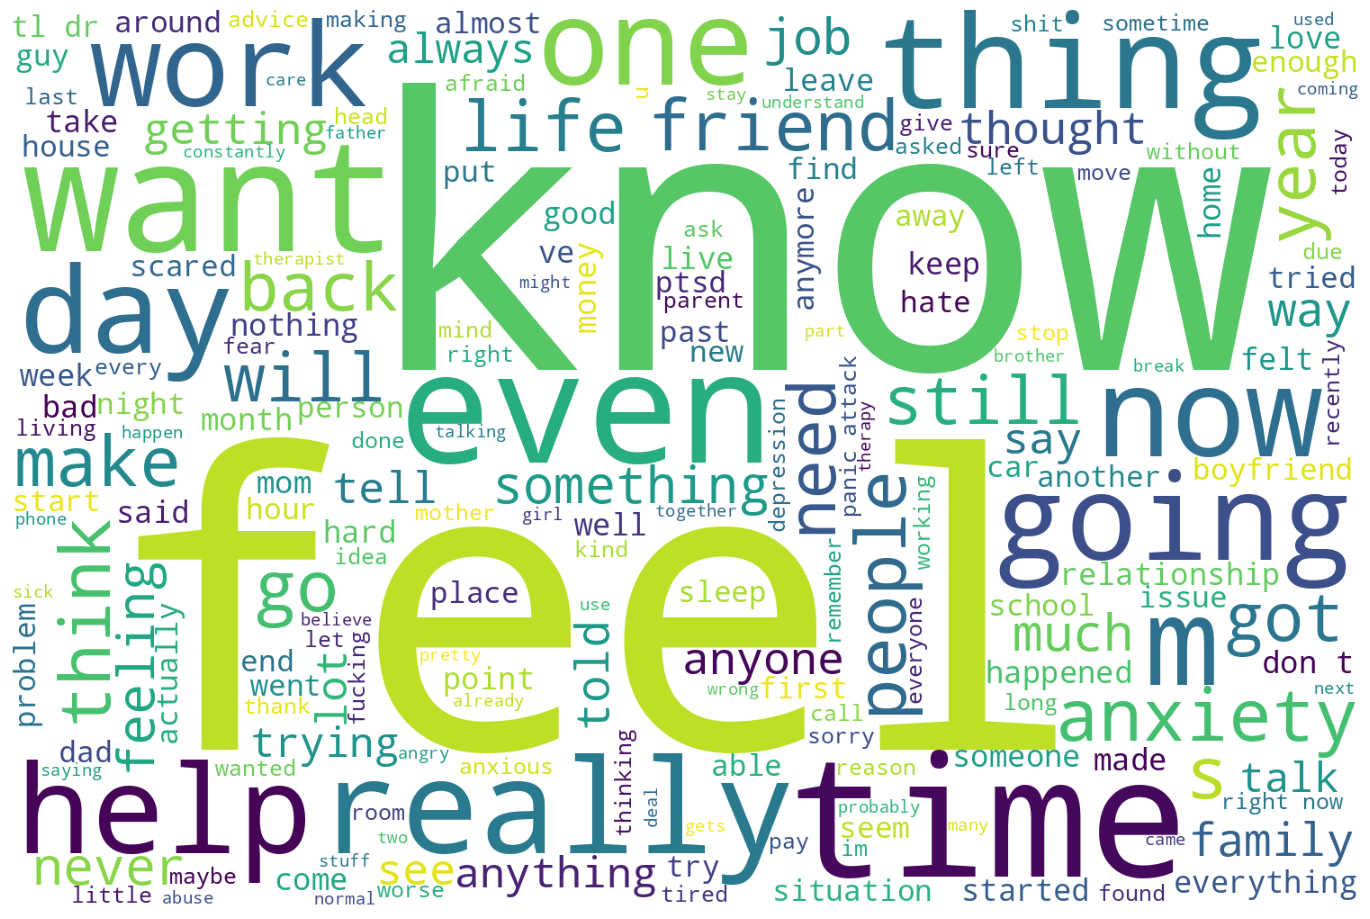

In [29]:
# Wordcloud function stress data
# Mengambil data text untuk melihat frequency data
stressText = stressData['text'].tolist()

# Join list and lowercase
stressText = ' '.join(stressText).lower()

# Define wordcloud
wordCloudStress = WordCloud(width = 1500, height = 1000,
                            background_color = 'white', 
                            min_font_size = 10).generate(stressText)

# Plot wordcloud
plt.figure(figsize = (16,9), facecolor=None)
plt.imshow(wordCloudStress)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

`feel`, `know`, `even`, `really` merupakan kata-kata yang sering digunakan jika seseorang sedang dalam kondisi stress.

In [30]:
# Make dictionary of stress
textDictStress = wordCloudStress.process_text(stressText)

# Sort dictionary
wordFreqStress = {k : v for k, v in sorted (textDictStress.items(), reverse = True, key=lambda item:item[1])}

# Use word
relFreqStress = wordCloudStress.words_

# Print top 10 frequency of word
print(list(wordFreqStress.items())[:10])
print()
print(list(relFreqStress.items())[:10])

[('feel', 598), ('know', 509), ('time', 415), ('even', 362), ('want', 356), ('really', 342), ('thing', 331), ('now', 306), ('m', 300), ('help', 294)]

[('feel', 1.0), ('know', 0.8511705685618729), ('time', 0.6939799331103679), ('even', 0.6053511705685619), ('want', 0.5953177257525084), ('really', 0.5719063545150501), ('thing', 0.5535117056856187), ('now', 0.5117056856187291), ('m', 0.5016722408026756), ('help', 0.4916387959866221)]


Berdasarkan hasil diatas menunjukan kalimat yang digunakan untuk mengekspresikan kondisi seseorang yang sedang stress adalah : 
1. `feel` sebanyak 598 kali
2. `know` sebanyak 509 kali
3. `time` sebanyak 415 kali
4. `even` sebanyak 362 kali
5. `want` sebanyak 356 kali
6. `really` sebanyak 342 kali
7. `thing` sebanyak 331 kali
8. `now` sebanyak 306 kali
9. `m` sebanyak 300 kali
10. `help` sebanyak 294 kali

Dari frekuensi kata yang sering muncul jika kondisi orang tersebut sedang stress dapat disimpulkan sebagai berikut:
1. `feel`, kata ini menandakan bagaimana perasaan orang tersebut pada saat itu dan ingin menunjukan jika memang kondisi saat itu sedang merasa tertekan atau stress.
2. `know`, kata ini dapat diartikan jika memang orang tersebut tahu seperti apa kondisi psikologis yang dialaminya, sehingga orang tersebut menggunakan `know` sebagai pengungkapan perasaan stress yang sedang dialami
3. `time`, kata berikut bisa diartikan bahwa orang yang sedang stress butuh waktu untuk memulihkan kembali psikologisnya hingga stress levelnya semakin membaik.

<Axes: >

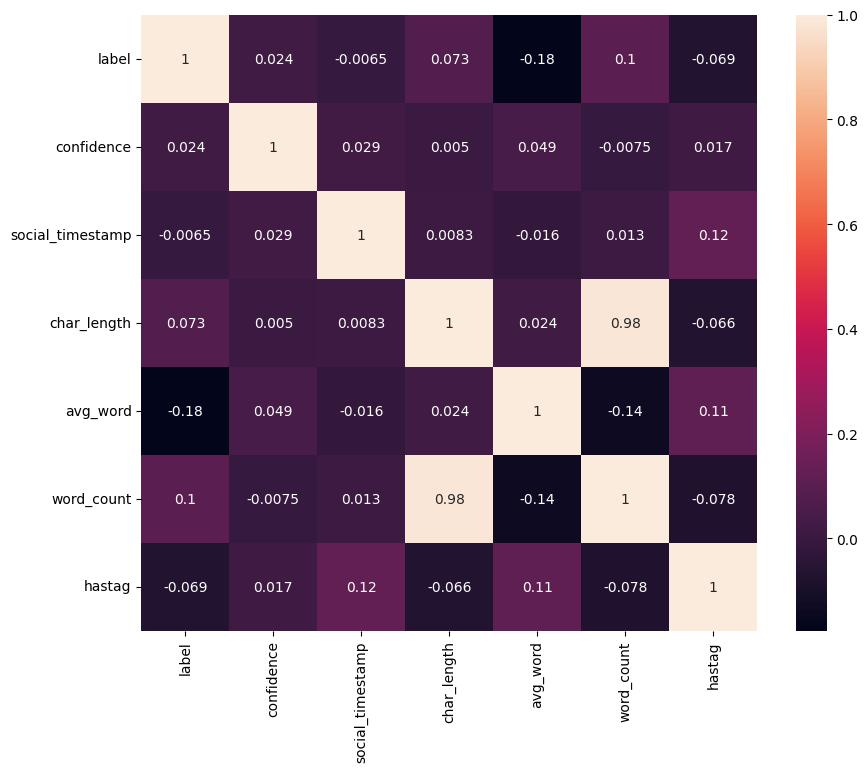

In [31]:
# Check correlation
corr = plt.figure(figsize = (10, 8))
sns.heatmap(copyData.corr(), annot=True, square=True)

# **6. Data Preprocessing**

---

## Text Preprocessing

Bagian ini berisi proses penyiapan data untuk proses pelatihan model, seperti pembagian data menjadi train-test, transformasi data (normalisasi, encoding, dll.), dan proses-proses lain yang dibutuhkan.

In [32]:
# Get sample of data
sample = copyData.text[19]
print(sample)

We had plans to move in together, a fancy $1,800/month home that she would contribute $400 or so. We spoke of children, marriage, all sorts of stuff. It's not that I thought she owed me anything for me doing these things. It's just that I felt like I did so incredibly much and it kills me that I look back and know that over a 5 month period, we only had intimate contact less than 15 times, that we never made out, outside sex (and I initiated and was rejected many, many times). Every time I brought up my frustrations regarding my unmet romantic needs, she took it as gaslighting and used it as fuel to further drive the reason why she wasn't comfortable with intimate contact.


In [33]:
# Mengubah sample ke Lowercase
lowerSample = sample.lower()
lowerSample

"we had plans to move in together, a fancy $1,800/month home that she would contribute $400 or so. we spoke of children, marriage, all sorts of stuff. it's not that i thought she owed me anything for me doing these things. it's just that i felt like i did so incredibly much and it kills me that i look back and know that over a 5 month period, we only had intimate contact less than 15 times, that we never made out, outside sex (and i initiated and was rejected many, many times). every time i brought up my frustrations regarding my unmet romantic needs, she took it as gaslighting and used it as fuel to further drive the reason why she wasn't comfortable with intimate contact."

In [34]:
# Menghilangkan Tanda Baca
sampleClean = lowerSample.translate(str.maketrans('', '', string.punctuation))
sampleClean

'we had plans to move in together a fancy 1800month home that she would contribute 400 or so we spoke of children marriage all sorts of stuff its not that i thought she owed me anything for me doing these things its just that i felt like i did so incredibly much and it kills me that i look back and know that over a 5 month period we only had intimate contact less than 15 times that we never made out outside sex and i initiated and was rejected many many times every time i brought up my frustrations regarding my unmet romantic needs she took it as gaslighting and used it as fuel to further drive the reason why she wasnt comfortable with intimate contact'

In [35]:
# Check punctuation
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

## Another Pre-processing

Preprocessing lain ditambahkan seperti:

1. Menghilangkan Hashtag.
2. Menghilangkan Enter.
3. Menghilangkan Whitespace.
4. Menghilangkan Link.
5. Menghilangkan Emoji, Simbol Matematika, dan karakter lain.
6. Menghilangkan *duplicate characters*.
7. Merapikan Spasi.

In [36]:
# Remove hashtag
sampleClean = re.sub('#[A-Za-z0-9_]+', ' ', sampleClean)

# Remove \n
sampleClean = re.sub(r'\\n', ' ', sampleClean)

# Remove whitespace
sampleClean = sampleClean.strip()

# Remove link
sampleClean = re.sub(r'http\S+', ' ', sampleClean)
sampleClean = re.sub(r'www.\S+', ' ', sampleClean)

# Remove duplicate character
sampleClean = re.sub('(.)\\1{2,}', '\\1', sampleClean)

# Cleaning spaces
print('Before Cleaning  : ', sampleClean)
cleanText = ' '.join(sampleClean.split())
print('After Cleaning   : ', cleanText)

Before Cleaning  :  we had plans to move in together a fancy 1800month home that she would contribute 400 or so we spoke of children marriage all sorts of stuff its not that i thought she owed me anything for me doing these things its just that i felt like i did so incredibly much and it kills me that i look back and know that over a 5 month period we only had intimate contact less than 15 times that we never made out outside sex and i initiated and was rejected many many times every time i brought up my frustrations regarding my unmet romantic needs she took it as gaslighting and used it as fuel to further drive the reason why she wasnt comfortable with intimate contact
After Cleaning   :  we had plans to move in together a fancy 1800month home that she would contribute 400 or so we spoke of children marriage all sorts of stuff its not that i thought she owed me anything for me doing these things its just that i felt like i did so incredibly much and it kills me that i look back and k

## Remove stopwords

In [37]:
# Stopword list in english
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [38]:
# Remove english stopwords
engStopword = list(set(stopwords.words('english')))
engStopword.append('i')

tokens = word_tokenize(sampleClean)
sampleStopword = ' '.join([word for word in tokens if word not in engStopword])

print('Document : ', sampleClean)
print('Tokens   : ', tokens)
print('Clean    : ', sampleStopword)

Document :  we had plans to move in together a fancy 1800month home that she would contribute 400 or so we spoke of children marriage all sorts of stuff its not that i thought she owed me anything for me doing these things its just that i felt like i did so incredibly much and it kills me that i look back and know that over a 5 month period we only had intimate contact less than 15 times that we never made out outside sex and i initiated and was rejected many many times every time i brought up my frustrations regarding my unmet romantic needs she took it as gaslighting and used it as fuel to further drive the reason why she wasnt comfortable with intimate contact
Tokens   :  ['we', 'had', 'plans', 'to', 'move', 'in', 'together', 'a', 'fancy', '1800month', 'home', 'that', 'she', 'would', 'contribute', '400', 'or', 'so', 'we', 'spoke', 'of', 'children', 'marriage', 'all', 'sorts', 'of', 'stuff', 'its', 'not', 'that', 'i', 'thought', 'she', 'owed', 'me', 'anything', 'for', 'me', 'doing', 

## Stemming

In [39]:
# Stemming using lancaster
lanc = LancasterStemmer()
stemText = lanc.stem(sampleStopword)

print('Document   : ', sampleClean)
print('Tokens     : ', tokens)
print('Clean      : ', sampleStopword)
print('Stemming   : ', stemText)

Document   :  we had plans to move in together a fancy 1800month home that she would contribute 400 or so we spoke of children marriage all sorts of stuff its not that i thought she owed me anything for me doing these things its just that i felt like i did so incredibly much and it kills me that i look back and know that over a 5 month period we only had intimate contact less than 15 times that we never made out outside sex and i initiated and was rejected many many times every time i brought up my frustrations regarding my unmet romantic needs she took it as gaslighting and used it as fuel to further drive the reason why she wasnt comfortable with intimate contact
Tokens     :  ['we', 'had', 'plans', 'to', 'move', 'in', 'together', 'a', 'fancy', '1800month', 'home', 'that', 'she', 'would', 'contribute', '400', 'or', 'so', 'we', 'spoke', 'of', 'children', 'marriage', 'all', 'sorts', 'of', 'stuff', 'its', 'not', 'that', 'i', 'thought', 'she', 'owed', 'me', 'anything', 'for', 'me', 'doin

## Preprocessing All Text

In [40]:
# Function for text pre-processing
def textProcess(text):
  # Change to lowercase
  text = text.lower()

  # Remove hashtag
  text = re.sub('#[A-Za-z0-9_]+', ' ', text)

  # Remove \n
  text = re.sub(r'\\n', ' ', text)

  # Remove whitespace
  text = text.strip()

  # Remove link
  text = re.sub(r'http\S+', ' ', text)
  text = re.sub(r'www.\S+', ' ', text)

  # Remove duplicate character
  text = re.sub('(.)\\1{2,}', '\\1', text)

  # Remove not char, emoji etc
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Spacing cleaning
  text = ' '.join(text.split())

  # Tokenize
  tokens = word_tokenize(text)

  # Remove Stopwords
  text = ' '.join([word for word in tokens if word not in engStopword])
  
  # Melakukan Stemming
  text = lanc.stem(text)
  
  return text

In [41]:
# Copy data
prepData = data.copy()

# Applying function
prepData['text_processed'] = prepData['text'].apply(lambda x: textProcess(x))
prepData

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,text_processed
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.800000,1521614353,said felt way suggeted go rest trigger ahead y...
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.000000,1527009817,hey r assistance sure right place post goes 'm...
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.800000,1535935605,mom hit newspaper shocked would knows n't like...
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.600000,1516429555,met new boyfriend amazing kind sweet good stud...
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.800000,1539809005,october domestic violence awareness month dome...
...,...,...,...,...,...,...,...,...
2833,relationships,7oee1t,"[35, 40]","* Her, a week ago: Precious, how are you? (I i...",0,1.000000,1515187044,week ago precious ignored jan happy year preci...
2834,ptsd,9p4ung,"[20, 25]",I don't have the ability to cope with it anymo...,1,1.000000,1539827412,n't ability cope anymore 'm trying lot things ...
2835,anxiety,9nam6l,"(5, 10)",In case this is the first time you're reading ...,0,1.000000,1539269312,case first time 're reading post looking peopl...
2836,almosthomeless,5y53ya,"[5, 10]",Do you find this normal? They have a good rela...,0,0.571429,1488938143,find normal good relationship main problem see...


## EDA after pre-processing

In [42]:
# Define stopwords
commentWord = ''
stopwordsPre = set(STOPWORDS)

# Iterate
for val in prepData.text_processed:
  
  # typecaste each val to string
  val = str(val)

  # split the value
  tokens = val.split()

  # Convert each token into lowercase
  for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()

  commentWord += ' '.join(tokens)+' '

# Define wordcloud
wcAfter = WordCloud(width=600, height=500, background_color='white',
                    stopwords=stopwordsPre, min_font_size=10).generate(commentWord)

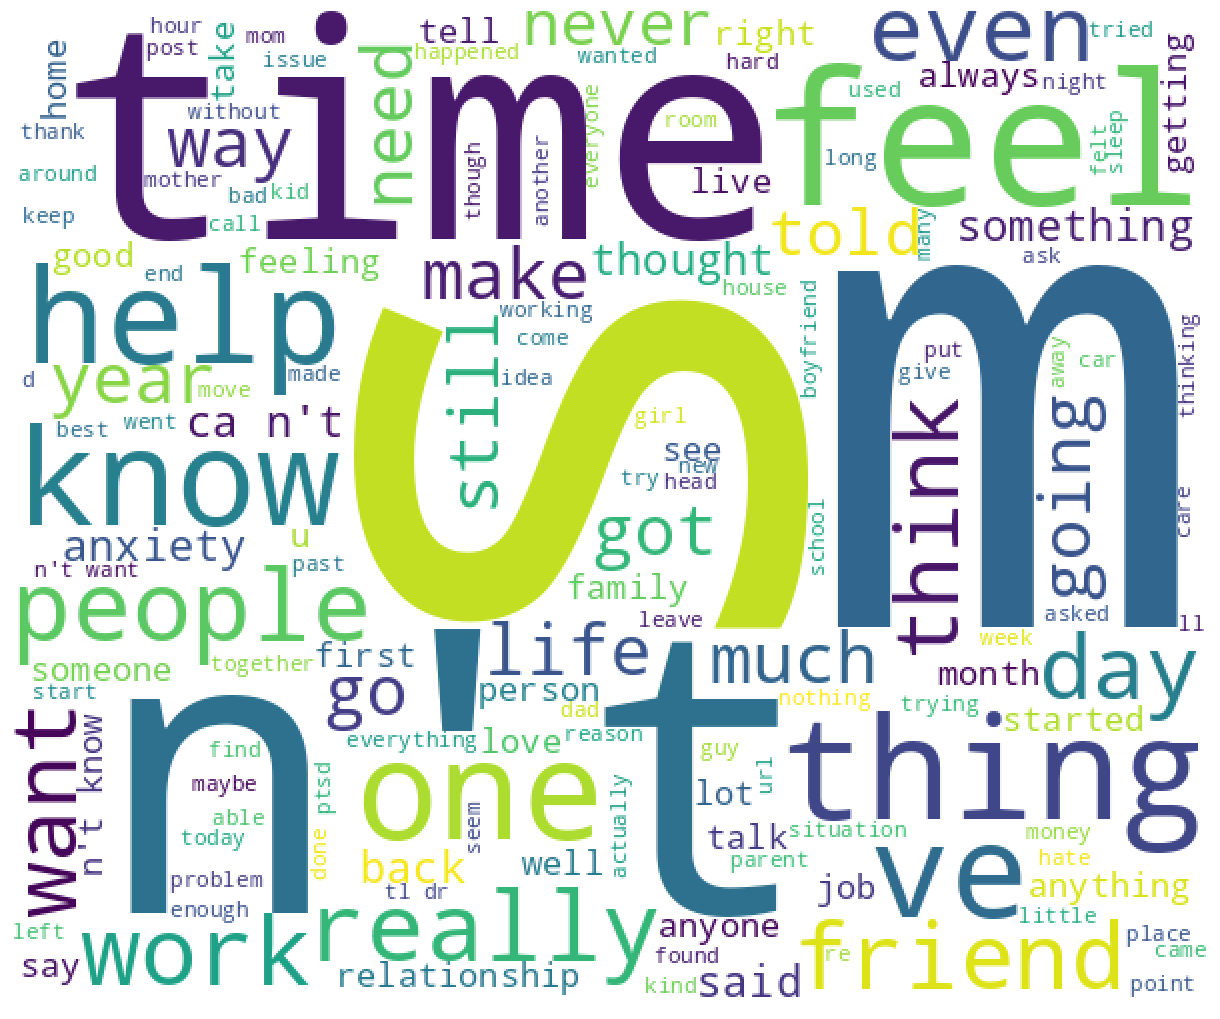

In [43]:
# Visualize wordcloud after pre-processing
plt.figure(figsize=(20,10))
plt.imshow(wcAfter)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [44]:
# Create dictionary from data frequency
prepDict = wcAfter.process_text(allText)

# Sort dictionary
prepWord = {k: v for k, v in sorted(prepDict.items(), reverse=True, key=lambda item: item[1])}

# Print word frequency
prepFreq = wcAfter.words_

# Display
print(list(prepWord.items())[:10])
print(list(prepFreq.items())[:10])

[('know', 811), ('feel', 774), ('time', 708), ('want', 579), ('thing', 566), ('really', 552), ('one', 543), ('help', 543), ('will', 500), ('even', 490)]
[('s', 1.0), ('m', 0.8491988689915174), ("n't", 0.8162111215834119), ('time', 0.6295947219604147), ('feel', 0.6239396795475967), ('thing', 0.5334590009425071), ('one', 0.5023562676720076), ('know', 0.4759660697455231), ('ve', 0.46277097078228085), ('help', 0.4580584354382658)]


In [45]:
# Copy data
prepCopy = prepData.copy()

In [46]:
# Get final data to modeling
prepData = prepData[['text', 'label', 'text_processed']]
prepData

,text,label,text_processed
0,"He said he had not felt that way before, sugge...",1,said felt way suggeted go rest trigger ahead y...
1,"Hey there r/assistance, Not sure if this is th...",0,hey r assistance sure right place post goes 'm...
2,My mom then hit me with the newspaper and it s...,1,mom hit newspaper shocked would knows n't like...
3,"until i met my new boyfriend, he is amazing, h...",1,met new boyfriend amazing kind sweet good stud...
4,October is Domestic Violence Awareness Month a...,1,october domestic violence awareness month dome...
...,...,...,...
2833,"* Her, a week ago: Precious, how are you? (I i...",0,week ago precious ignored jan happy year preci...
2834,I don't have the ability to cope with it anymo...,1,n't ability cope anymore 'm trying lot things ...
2835,In case this is the first time you're reading ...,0,case first time 're reading post looking peopl...
2836,Do you find this normal? They have a good rela...,0,find normal good relationship main problem see...


In [47]:
# Show total of word after pre-processing
prepCopy['word_count'] = prepCopy['text_processed'].apply(lambda x: len(str(x).split()))
prepCopy

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,text_processed,word_count
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.800000,1521614353,said felt way suggeted go rest trigger ahead y...,54
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.000000,1527009817,hey r assistance sure right place post goes 'm...,62
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.800000,1535935605,mom hit newspaper shocked would knows n't like...,70
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.600000,1516429555,met new boyfriend amazing kind sweet good stud...,111
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.800000,1539809005,october domestic violence awareness month dome...,45
...,...,...,...,...,...,...,...,...,...
2833,relationships,7oee1t,"[35, 40]","* Her, a week ago: Precious, how are you? (I i...",0,1.000000,1515187044,week ago precious ignored jan happy year preci...,37
2834,ptsd,9p4ung,"[20, 25]",I don't have the ability to cope with it anymo...,1,1.000000,1539827412,n't ability cope anymore 'm trying lot things ...,71
2835,anxiety,9nam6l,"(5, 10)",In case this is the first time you're reading ...,0,1.000000,1539269312,case first time 're reading post looking peopl...,69
2836,almosthomeless,5y53ya,"[5, 10]",Do you find this normal? They have a good rela...,0,0.571429,1488938143,find normal good relationship main problem see...,32


## Split between feature and target

In [48]:
# Splitting data
# Data features
X = prepData.drop(['label', 'text'], axis=1).to_numpy()

# Data Target
y = prepData['label'].to_numpy()

# Display
X

array([["said felt way suggeted go rest trigger ahead youi 're hypocondriac like decide look feelings doom hopes maybe getting sucked rabbit hole ludicrous conspiracy stupid psychic test new age b something could even laugh road ended reading sense doom indicative various health ailments one prone top doom gloom f'n worried heart happen physical hours"],
       ["hey r assistance sure right place post goes 'm currently student intern sandia national labs working survey help improve marketing outreach efforts many schools recruit around country 're looking current undergrad grad stem students 're stem student know stem students would greatly appreciate help take pass along short survey thank everyone helps take survey entered drawing chance win one three amazon gcs"],
       ["mom hit newspaper shocked would knows n't like play hitting smacking striking hitting violence sort person send vibe asking universe yesterday decided take friend go help another friend move new place driving frie

## Split between Train, validation and test

In [49]:
# Splitting data train, val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=19)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=19)

# Check size of split
print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (1816, 1)
Val Size   :  (454, 1)
Test Size  :  (568, 1)


In [50]:
# Change shape of data
X_train = X_train.flatten()
X_val = X_val.flatten()
X_test = X_test.flatten()

# Display
print('Train Size : ', X_train.shape)
print('Val Size   : ', X_val.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (1816,)
Val Size   :  (454,)
Test Size  :  (568,)


In [51]:
# Get Vocabularies
Vectorize = CountVectorizer()

# Vectorizing
X_trainVec = Vectorize.fit_transform(X_train)
X_valVec = Vectorize.transform(X_val)
X_testVec = Vectorize.transform(X_test)

# Display
X_trainVec

<1816x8861 sparse matrix of type '<class 'numpy.int64'>'
	with 62366 stored elements in Compressed Sparse Row format>

In [52]:
# Find total vocab and token length in one text
sumVocab = len(Vectorize.vocabulary_.keys())
maxLength = max([len(i.split(' ')) for i in X_train])

print('Total Vocabulary         : ', sumVocab)
print('Word Length in one text  : ', maxLength)

Total Vocabulary         :  8861
Word Length in one text  :  151


*Get vocabulary* digunakan untuk identifikasi kata penting dalam suatu bahasa yang akan digunakan sebagai dasar analisis dan pemrosesan teks. Selain itu, *get vocabulary* juga digunakan untuk membersihkan dan membuang kata-kata yang tidak relevan dalam proses pemrosesan teks, seperti tanda baca, stopword, dan kata-kata dengan frekuensi rendah yang tidak signifikan dalam analisis.

## Text Vectorization

In [53]:
# Text Vectorization
textVect = TextVectorization(max_tokens=sumVocab, standardize='lower_and_strip_punctuation',
                             split='whitespace', ngrams=None, output_mode='int',
                             output_sequence_length=maxLength, input_shape=(1,))

# Applying function
textVect.adapt(X_train)

In [54]:
# Get sample of text vectorization
print('Sample Text')
print(prepData.text_processed[19])
print('')

# vectorization results
print('Vectorization results')
print(textVect([prepData.text_processed[19]]))
print('Vector Size : ', textVect([prepData.text_processed[4]]).shape)

Sample Text
plans move together fancy month home would contribute spoke children marriage sorts stuff 's thought owed anything things 's felt like incredibly much kills look back know month period intimate contact less times never made outside sex initiated rejected many many times every time brought frustrations regarding unmet romantic needs took gaslighting used fuel drive reason n't comfortable intimate contact

Vectorization results
tf.Tensor(
[[1032  176   90 7508  149   48    9 1471 1015  463  690 2293  212    4
    81 2392   49   26    4  119    5 1304   23 2444  248   20    6  149
   806 1425  307  208   98   27   73  509  261 4056 1745  133  133   98
    66   10  465 7356 1552 4950 1103  373  195 4165  188 2497  607  203
     2  462 1425  307    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0  

In [55]:
# Show top 20 token
textVect.get_vocabulary()[:20]

['',
 '[UNK]',
 'nt',
 'm',
 's',
 'like',
 'know',
 'get',
 'feel',
 'would',
 'time',
 'really',
 'even',
 'want',
 'one',
 've',
 'help',
 'people',
 'go',
 'could']

## Embedding

In [57]:
# Embedding
embedding = Embedding(input_dim=sumVocab, output_dim=128,
                      embeddings_initializer='uniform', input_length=maxLength)

Dalam proses embbeding ini, digunakan dimensi input (`input_dim`) sebanyak jumlah vocabulary (`sum_vocab`). Sedangkan [output_dim](https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce) atau panjang dari vector setiap kata, menggunakan 128.

In [58]:
# Sample embedding
print('Sample Text')
print(prepData.text_processed[19])
print('='*100)

# vectorization results
print('Vectorization results')
print(textVect([prepData.text_processed[19]]))
print('Vector Size : ', textVect([prepData.text_processed[19]]).shape)
print('='*100)

# Embedding results
print('Embedding results')
print(embedding(textVect([prepData.text_processed[19]])))
print('Vector Embedding Size : ', embedding(textVect([prepData.text_processed[19]])).shape)

Sample Text
plans move together fancy month home would contribute spoke children marriage sorts stuff 's thought owed anything things 's felt like incredibly much kills look back know month period intimate contact less times never made outside sex initiated rejected many many times every time brought frustrations regarding unmet romantic needs took gaslighting used fuel drive reason n't comfortable intimate contact
Vectorization results
tf.Tensor(
[[1032  176   90 7508  149   48    9 1471 1015  463  690 2293  212    4
    81 2392   49   26    4  119    5 1304   23 2444  248   20    6  149
   806 1425  307  208   98   27   73  509  261 4056 1745  133  133   98
    66   10  465 7356 1552 4950 1103  373  195 4165  188 2497  607  203
     2  462 1425  307    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   

## TensorFlow Pipeline

In [59]:
# Create a tensorflow pipeline
def df_to_dataset(features, labels, shuffle=True, batch_size=64):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(features))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

# Applying pipeline
trainPipe = df_to_dataset(X_train, y_train, batch_size=64)
valPipe = df_to_dataset(X_val, y_val, batch_size=64)
testPipe = df_to_dataset(X_test, y_test, batch_size=64)

# Display
print('Number batch size of Train : ', tf.data.experimental.cardinality(trainPipe).numpy())
print('Number batch size of Val   : ', tf.data.experimental.cardinality(valPipe).numpy())
print('Number batch size of Test  : ', tf.data.experimental.cardinality(testPipe).numpy())

Number batch size of Train :  29
Number batch size of Val   :  8
Number batch size of Test  :  9


# **7 - Model Definition**

---

Bagian ini berisi cell untuk mendefinisikan model. Jelaskan alasan menggunakan suatu algoritma/model, hyperparameter yang dipakai, jenis penggunaan metrics yang dipakai, dan hal lain yang terkait dengan model.

## Sequential API - LSTM

In [136]:
# Clear session
seed = 19
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [137]:
# Define model LSTM
%%time
seqBase = Sequential()
seqBase.add(textVect)
seqBase.add(embedding)
seqBase.add(LSTM(64, return_sequences=True))
seqBase.add(LSTM(32))
seqBase.add(tf.keras.layers.Dropout(0.1))
seqBase.add(Dense(1, activation='sigmoid'))

# Compile the model
seqBase.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
seqBase.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 151)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 151, 128)          1134208   
                                                                 
 lstm (LSTM)                 (None, 151, 64)           49408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                        

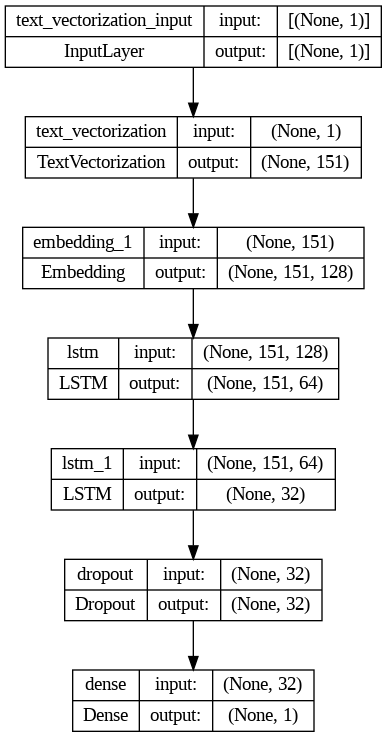

In [138]:
# Plot layers
tf.keras.utils.plot_model(seqBase, show_shapes=True)

## Model Training

---



Cell pada bagian ini hanya berisi code untuk melatih model dan output yang dihasilkan. Lakukan beberapa kali proses training dengan hyperparameter yang berbeda untuk melihat hasil yang didapatkan. Analisis dan narasikan hasil ini pada bagian Model Evaluation.

In [139]:
# Train the base model
%%time
model1 = seqBase.fit(trainPipe, epochs=20, validation_data=valPipe)

Epoch 1/20
29/29 [==============================] - 21s 441ms/step - loss: 0.6926 - accuracy: 0.5248 - val_loss: 0.6922 - val_accuracy: 0.5242
Epoch 2/20
29/29 [==============================] - 18s 640ms/step - loss: 0.6932 - accuracy: 0.5270 - val_loss: 0.6921 - val_accuracy: 0.5242
Epoch 3/20
29/29 [==============================] - 11s 391ms/step - loss: 0.6926 - accuracy: 0.5264 - val_loss: 0.6922 - val_accuracy: 0.5242
Epoch 4/20
29/29 [==============================] - 12s 424ms/step - loss: 0.6922 - accuracy: 0.5264 - val_loss: 0.6920 - val_accuracy: 0.5242
Epoch 5/20
29/29 [==============================] - 10s 355ms/step - loss: 0.6919 - accuracy: 0.5270 - val_loss: 0.6921 - val_accuracy: 0.5242
Epoch 6/20
29/29 [==============================] - 12s 423ms/step - loss: 0.6928 - accuracy: 0.5248 - val_loss: 0.6920 - val_accuracy: 0.5242
Epoch 7/20
29/29 [==============================] - 12s 400ms/step - loss: 0.6925 - accuracy: 0.5264 - val_loss: 0.6920 - val_accuracy: 0.5242

In [142]:
# Create dataframe to save the base model result
histModel1 = pd.DataFrame(model1.history)

# Display
histModel1

,loss,accuracy,val_loss,val_accuracy
0,0.692649,0.524780,0.692173,0.524229
1,0.693163,0.526982,0.692068,0.524229
2,0.692560,0.526432,0.692176,0.524229
3,0.692196,0.526432,0.691979,0.524229
4,0.691932,0.526982,0.692055,0.524229
5,0.692757,0.524780,0.691991,0.524229
6,0.692477,0.526432,0.691980,0.524229
7,0.692534,0.529185,0.691978,0.524229
8,0.692098,0.526432,0.691988,0.524229
9,0.691570,0.526432,0.691979,0.524229


<Axes: >

<Figure size 1500x800 with 0 Axes>

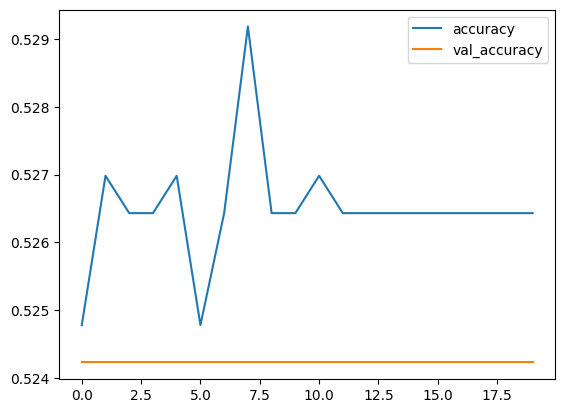

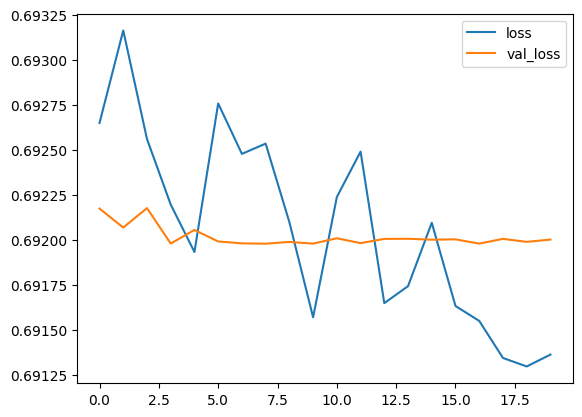

In [143]:
# Plotting the result
plt.figure(figsize=(15, 8))
histModel1[['accuracy', 'val_accuracy']].plot()
histModel1[['loss', 'val_loss']].plot()

## Improvement API - BiLSTM

In [128]:
# Clear session
seed = 19
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [129]:
# Define the BiLSTM
%%time
seqImp = Sequential()
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7)
seqImp.add(textVect)
seqImp.add(embedding)
seqImp.add(tf.keras.layers.BatchNormalization())
seqImp.add(tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)))
seqImp.add(tf.keras.layers.Bidirectional(LSTM(32, return_sequences=False)))
seqImp.add(tf.keras.layers.Dropout(0.05))
seqImp.add(Dense(1, activation='sigmoid'))

# Compile the model
seqImp.compile(loss='binary_crossentropy', optimizer='sgd', metrics='accuracy')
seqImp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 151)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 151, 128)          1134208   
                                                                 
 batch_normalization (BatchN  (None, 151, 128)         512       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 151, 256)         263168    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               73984     
 nal)                                                   

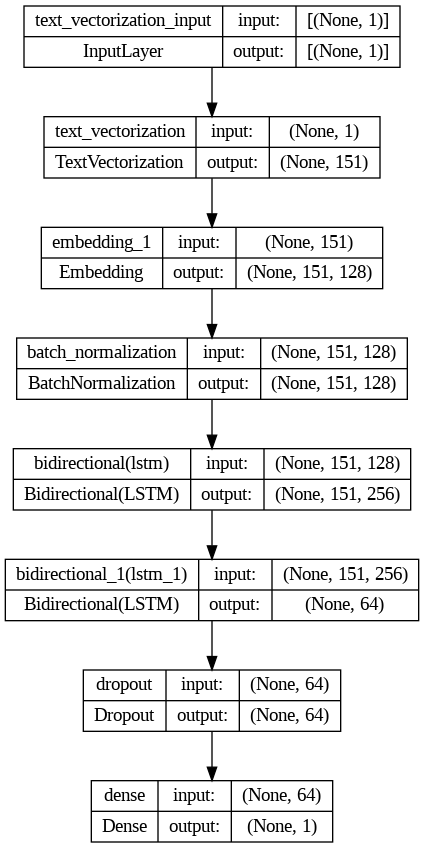

In [130]:
# Plot layers
tf.keras.utils.plot_model(seqImp, show_shapes=True)

## Model Training

In [131]:
# Train the model
%%time
model2 = seqImp.fit(trainPipe, epochs=30, callbacks=callback,
                    validation_data=valPipe)

Epoch 1/30
29/29 [==============================] - 51s 1s/step - loss: 0.6965 - accuracy: 0.5006 - val_loss: 0.6925 - val_accuracy: 0.5264
Epoch 2/30
29/29 [==============================] - 39s 1s/step - loss: 0.6878 - accuracy: 0.5479 - val_loss: 0.6927 - val_accuracy: 0.5374
Epoch 3/30
29/29 [==============================] - 40s 1s/step - loss: 0.6828 - accuracy: 0.5666 - val_loss: 0.6921 - val_accuracy: 0.5529
Epoch 4/30
29/29 [==============================] - 46s 2s/step - loss: 0.6766 - accuracy: 0.5771 - val_loss: 0.6913 - val_accuracy: 0.5595
Epoch 5/30
29/29 [==============================] - 38s 1s/step - loss: 0.6714 - accuracy: 0.6024 - val_loss: 0.6908 - val_accuracy: 0.5793
Epoch 6/30
29/29 [==============================] - 38s 1s/step - loss: 0.6661 - accuracy: 0.6189 - val_loss: 0.6896 - val_accuracy: 0.5727
Epoch 7/30
29/29 [==============================] - 41s 1s/step - loss: 0.6608 - accuracy: 0.6134 - val_loss: 0.6887 - val_accuracy: 0.5749
Epoch 8/30
29/29 [==

In [133]:
# Create dataframe to save the result
histModel2 = pd.DataFrame(model2.history)

# Display
histModel2

,loss,accuracy,val_loss,val_accuracy
0,0.696526,0.500551,0.692492,0.526432
1,0.687819,0.547907,0.692749,0.537445
2,0.682816,0.566630,0.692071,0.552863
3,0.676634,0.577093,0.691343,0.559471
4,0.671414,0.602423,0.690835,0.579295
5,0.666096,0.618943,0.689575,0.572687
6,0.660833,0.613436,0.688670,0.574890
7,0.653074,0.620044,0.687354,0.618943
8,0.648637,0.633260,0.685766,0.577093
9,0.638378,0.664648,0.682682,0.621145


<Axes: >

<Figure size 1500x800 with 0 Axes>

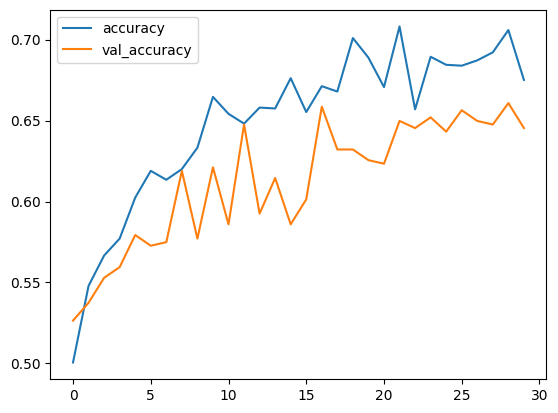

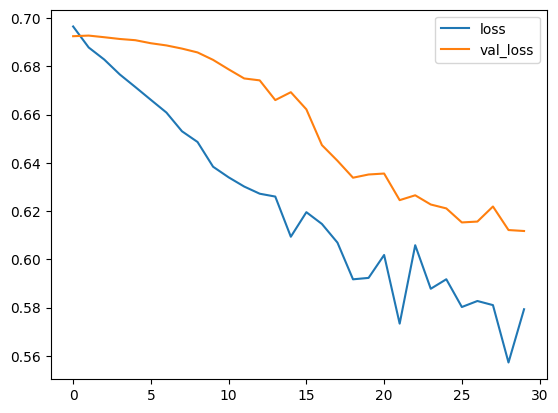

In [134]:
# Visualize the result
plt.figure(figsize=(15,8))
histModel2[['accuracy', 'val_accuracy']].plot()
histModel2[['loss', 'val_loss']].plot()

# **9 - Model Evaluation**

---

Pada bagian ini, dilakukan evaluasi model yang harus menunjukkan bagaimana performa model berdasarkan metrics yang dipilih. Hal ini harus dibuktikan dengan visualisasi tren performa dan/atau tingkat kesalahan model. Lakukan analisis terkait dengan hasil pada model dan tuliskan hasil analisisnya.

## Evaluate model with train-set

In [145]:
# Evaluate model with train-set
%%time
predTrainModel1 = seqBase.predict(X_train)
predTrainModel2 = seqImp.predict(X_train)

57/57 [==============================] - 13s 235ms/step
CPU times: user 24.3 s, sys: 767 ms, total: 25.1 s
Wall time: 25.5 s


In [146]:
# Convert the result
predTrainModel1 = np.where(predTrainModel1 >= 0.5, 1, 0)
predTrainModel2 = np.where(predTrainModel2 >= 0.5, 1, 0)

In [150]:
# Evaluate with classification report
print('Classification Report Train-set Baseline - LSTM')
print(classification_report(y_train, predTrainModel1))
print('='*55)
print('Classification Report Train-set Improvement - BiLSTM')
print(classification_report(y_train, predTrainModel2))

Classification Report Train-set Baseline - LSTM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       860
           1       0.53      1.00      0.69       956

    accuracy                           0.53      1816
   macro avg       0.26      0.50      0.34      1816
weighted avg       0.28      0.53      0.36      1816

Classification Report Train-set Improvement - BiLSTM
              precision    recall  f1-score   support

           0       0.70      0.87      0.78       860
           1       0.85      0.67      0.75       956

    accuracy                           0.76      1816
   macro avg       0.78      0.77      0.76      1816
weighted avg       0.78      0.76      0.76      1816



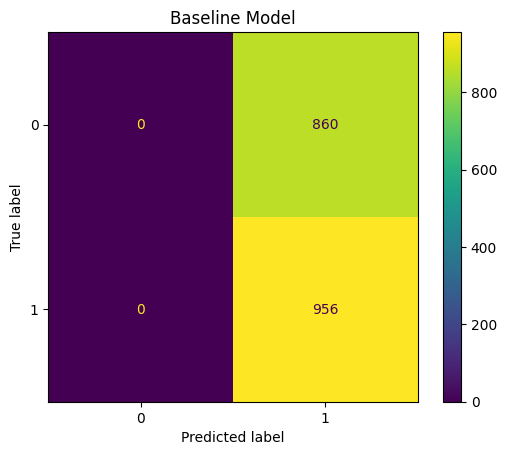

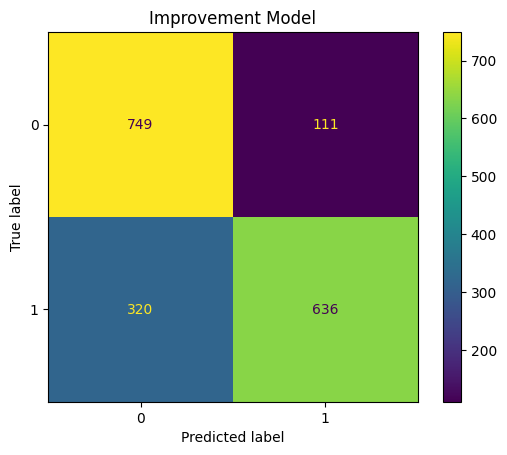

In [154]:
# Evaluate with confussion matrix
# Baseline model
cm1 = confusion_matrix(y_train, predTrainModel1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)

# Display
disp1.plot()
plt.title('Baseline Model')
plt.show()

# Improvement model
cm2 = confusion_matrix(y_train, predTrainModel2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)

# Display
disp2.plot()
plt.title('Improvement Model')
plt.show()

# **10 - Model Inference**

---

Model yang sudah dilatih akan dicoba pada data yang bukan termasuk ke dalam train-set ataupun test-set. Data ini harus dalam format yang asli, bukan data yang sudah di-scaled.

# **11 - Model Saving**

---


# **12 - Pengambilan Kesimpulan**

---


Pada bagian terakhir ini, harus berisi kesimpulan yang mencerminkan hasil yang didapat dengan objective yang sudah ditulis di bagian pengenalan.